# Predicting Molecular Properties with Graph Neural Networks

This notebook provides you with a complete code example to predict the properties of small molecules using graph convolutional layers with message passing.


## Understanding Graph Convolutions

Calculate the adjacency matrix of a simple cycle graph ...


In [ ]:
# set torch device to mps
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


In [24]:
import numpy as np

node_num = 5

A = np.zeros((node_num, node_num))
for i in range(node_num):
    for j in range(node_num):
        if j % node_num == (i + 1) % node_num:
            A[i, j] = 1

print("A:\n", A)

A:
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


... assign node features ...


In [25]:
x = np.zeros(node_num)
x[0] = 1

print("x:", x)




x: [1. 0. 0. 0. 0.]
tensor([1.], device='mps:0')


... implement a function to perform a graph convolution ...


In [26]:
def graph_convolution(A, x):
    """Calculate graph convolution."""
    conv = np.zeros(node_num)
    for i in range(node_num):
        for j in range(node_num):
            conv[j] += A[i, j] * x[i]
    return conv

... and apply the graph convolution.


In [27]:
for c in range(5):
    x = graph_convolution(A, x)
    print(f"Convolution {c + 1}: ", x)

IndexError: index 1 is out of bounds for dimension 0 with size 1

## Predicting Molecular Properties with Graph Convolutions


### Implementing a Graph Convolution Layer

Define a class to implement a graph convolution ...


In [ ]:
import torch.nn as nn

class GraphConvolution(nn.Module):
    """Graph convolution."""
    
    def forward(self, A, x):
        """Calculate forward pass."""
        return A @ x

... and a class to implement the class convolution layer.


In [ ]:
import deeplay as dl
import torch

class GCL(dl.DeeplayModule):
    """Graph convolution layer."""
    
    def __init__(self, in_features, out_features):
        """Initialize graph convolution layer."""
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.Transform = dl.Layer(nn.Linear, in_features, out_features)
        self.Propagate = dl.Layer(GraphConvolution)
        self.Update = dl.Layer(nn.ReLU)

    def diagonalize(self, A):
        """Add diagonal to adjacency matrix."""
        return A + torch.eye(A.size(0)).to(A.device)
    
    def normalize(seft, A):
        """Normalize ajacency matrix."""
        deg = torch.sum(A, dim=1)
        deg = deg.pow(-0.5)
        deg[deg == float("inf")] = 0
        D = torch.diag(deg)
        return D @ A @ D

    def forward(self, A, x):
        """Calculate forward pass."""
        A = self.diagonalize(A)
        A = self.normalize(A)
        x = self.Transform(x)
        x = self.Propagate(A, x)
        x = self.Update(x)
        return x

### Using the ZINC Dataset

Download the ZINC dataset ...


In [ ]:
from torch_geometric.datasets import ZINC

train_dataset = ZINC(root="ZINC_dataset/", subset=True, split="train")
val_dataset = ZINC(root="ZINC_dataset/", subset=True, split="val")
test_dataset = ZINC(root="ZINC_dataset/", subset=True, split="test")

Extracting ZINC_dataset/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 17993.97it/s]
Done!


... implement a function to plot the adjacency matrix of a molecule ...


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from torch_geometric.utils import to_dense_adj

def plot_molecule(molecule):
    """Plot adjacency matrix of a molecule."""
    x = molecule["x"].numpy().squeeze()
    A = to_dense_adj(molecule["edge_index"]).numpy().squeeze(0)
    y = molecule["y"].item()
    
    fig, ax = plt.subplots()
    ax.matshow(A, cmap=colormaps["gray"].reversed())

    indices = np.arange(len(x))
    ax.set_xticks(indices, x, fontsize=12)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Atom type', fontsize=16)

    ax.set_yticks(indices, x, fontsize=12)
    ax.set_ylabel('Atom type', fontsize=16)
    
    ax.set_title(f"LogP={np.round(y, 2)}", fontsize=24)
    plt.show()

... and use to visualize the structures of some molecules.


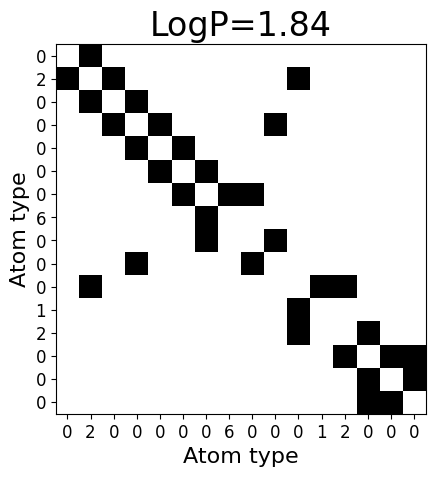

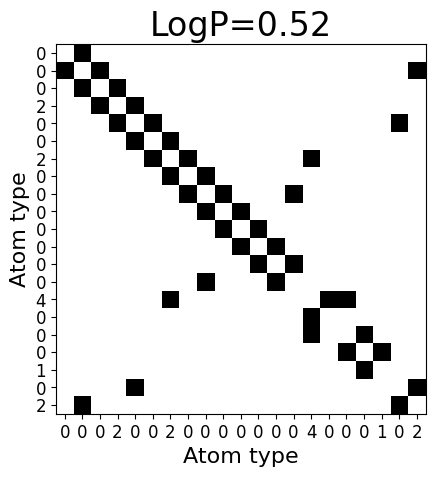

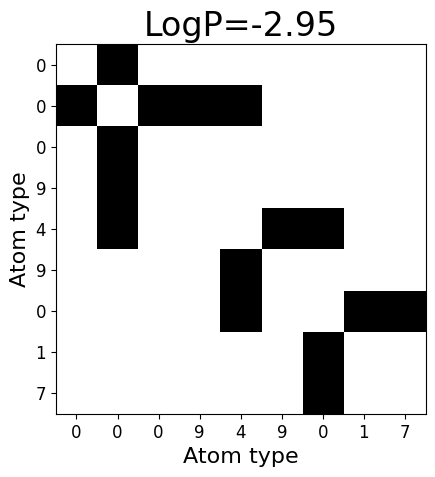

In [ ]:
for i in [2, 1235, 9887]:
    plot_molecule(molecule=train_dataset[i])

### Implementing a Graph Convolutional Network

Create a class to implement a graph convolutional network ...


In [ ]:
class GCN(dl.DeeplayModule):
    """Graph convolutional network."""

    def __init__(self, num_node_embedding, embedding_dim, hidden_features, 
                 out_features):
        """Initialize graph convolutional network."""
        super().__init__()
        
        self.num_node_embedding = num_node_embedding
        self.hidden_features = hidden_features
        self.out_features = out_features
        
        self.node_embedding = dl.Layer(nn.Embedding, num_node_embedding,
                                       embedding_dim)
        
        self.blocks = dl.LayerList()
        for f_in, f_out in zip([embedding_dim, *hidden_features[:-1]],
                               [*hidden_features, out_features]):
            self.blocks.append(GCL(f_in, f_out))
        
        self.dense_top = dl.Sequential(
			dl.Layer(nn.Linear, hidden_features[-1], hidden_features[-1] // 4),
			dl.Layer(nn.ReLU),
			dl.Layer(nn.Linear, hidden_features[-1] // 4, out_features),
		)

    def forward(self, G):
        """Calculate forward pass."""
        G["x"] = self.node_embedding(G["x"])
        for block in self.blocks:
            G["x"] = block(G["A"], G["x"])
        
        batch_size = torch.max(G["batch"]) + 1
        h = torch.zeros(batch_size, G["x"].shape[1], device=G["x"].device)
        h = h.scatter_add(0, G["batch"][:, None].expand_as(G["x"]), G["x"])
        h = h / torch.bincount(G["batch"])[:, None]
         
        return self.dense_top(h).squeeze()

... instantiate it ...


In [ ]:
gcn_model = GCN(
    num_node_embedding=28,
    embedding_dim=64,
    hidden_features=[64, 64, 64, 64],
    out_features=1,
).create()

print(gcn_model)

GCN(
  (node_embedding): Embedding(28, 64)
  (blocks): LayerList(
    (0-3): 4 x GCL(
      (Transform): Linear(in_features=64, out_features=64, bias=True)
      (Propagate): GraphConvolution()
      (Update): ReLU()
    )
  )
  (dense_top): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


... define the data loaders ...


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

... implement a class to compile, train, and evaluate the graph convolutional network ...


In [ ]:
class MolecularRegressor(dl.Regressor):
    """Molecular regressor."""

    def __init__(self, model, **kwargs):
        """Initialize molecular regressor."""
        super().__init__(model, **kwargs)
    
    def batch_preprocess(self, batch):
        """Preprocess batch."""
        batch["x"] = batch["x"].squeeze()
        batch["A"] = to_dense_adj(batch["edge_index"]).squeeze(0)
        return batch.to(self.device)
    
    def forward(self, batch):
        """Calculate forward pass."""
        return self.model(self.batch_preprocess(batch))

... and train the graph convolutional network.


In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

gcn = MolecularRegressor(
    gcn_model, loss=nn.L1Loss(), optimizer=dl.Adam(lr=1e-3)
).create()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="models",
    filename="ZINC-GCN-model{epoch:02d}-val_loss{val_loss:.2f}",
    auto_insert_metric_name=False,
)
trainer = dl.Trainer(max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(gcn, train_loader, val_loader)

Missing logger folder: /Users/felixwaldschock/Documents/gits/TIF360_Advanced_machine_learning_with_neural_networks_V2/03_Workshops/08_Transformer_Graph_Intro/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | GCN              | 19.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
19.5 K    Trainable params
0         Non-trainable params
19.5 K    Total params
0.078     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Evaluating the Trained Graph Convolutional Network

Evaluate the performance of the trained graph convolutional network ...


In [ ]:
import glob
import os

best_model_path = glob.glob(os.path.join("models", "ZINC-GCN-model*.ckpt"))
best_model_path = sorted(best_model_path, key=os.path.getmtime)[-1]
gcn_best = MolecularRegressor.load_from_checkpoint(
    best_model_path, 
    model=gcn_model, 
    loss=nn.L1Loss(),
)
test_results = trainer.test(gcn_best, test_loader)

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.47084325551986694    │
└───────────────────────────┴───────────────────────────┘

... obtain the predicted and actual logP ...


In [ ]:
gts, preds = [], []
for batch in test_loader:
    y = batch.pop("y")
    gts.append(y)
    
    pred = gcn_best(batch)
    preds.append(pred)
    
gts = torch.cat(gts).cpu().numpy()
preds = torch.cat(preds).detach().cpu().numpy()

... and plot the predicted logP versus their ground truth values.


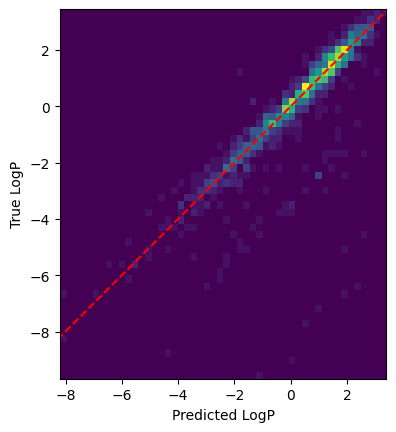

In [ ]:
heatmap, xedges, yedges = np.histogram2d(preds, gts, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.plot([min(gts), max(gts)], [min(gts), max(gts)], "r--")
plt.imshow(heatmap.T, extent=extent, origin="lower")
plt.xlabel("Predicted LogP")
plt.ylabel("True LogP")
plt.show()

## Predicting Molecular Properties with Message Passing


### Implementing a Message Passing Layer

Implement a class to implement a layer to perform the transform step ...


In [ ]:
class TransformLayer(nn.Module):
    """Transform layer."""

    def __init__(self, hidden_features):
        """Initialize the transform layer."""
        super().__init__()

        self.hideen_features = hidden_features
        self.layer = nn.LazyLinear(hidden_features)
        self.activation = nn.ReLU()

    def forward(self, G):
        """Calculate forward pass."""
        G["message"] = torch.cat(
            [
                G["x"][G["edge_index"][0]],
                G["x"][G["edge_index"][1]],
                G["edge_attr"],
            ],
            dim=-1,
        )
        G["message"] = self.layer(G["message"])
        G["message"] = self.activation(G["message"])
        return G

... a class to implement a layer to perform the propagate step ...


In [ ]:
class PropagateLayer(nn.Module):
    """PropagateLayer."""

    def __init__(self, hidden_features):
        """Initialize propagate layer."""
        super().__init__()
        self.hidden_features = hidden_features

    def forward(self, G):
        """Calculate forward pass."""
        G["aggregate"] = torch.zeros(G["x"].size(0), self.hidden_features)
        G["aggregate"] = G["aggregate"].type_as(G["x"])
        G["aggregate"] = G["aggregate"].to(G["x"].device)
        
        indices = G["edge_index"][1].unsqueeze(1).expand_as(G["message"])
        G["aggregate"] = G["aggregate"].scatter_add(0, indices, G["message"])
        
        return G

... a class to implement a layer to perform the update step ...


In [ ]:
class UpdateLayer(nn.Module):
    """Update layer."""

    def __init__(self, hidden_features):
        """Initialize update layer."""
        super().__init__()
        self.hidden_features = hidden_features
        self.layer = nn.LazyLinear(hidden_features)
        self.activation = nn.ReLU()

    def forward(self, G):
        """Calculate forward pass."""
        G["x"] = self.layer(
            torch.cat(
                [
                    G["x"],
                    G["aggregate"],
                ],
                dim=-1,
            )
        )
        G["x"] = self.activation(G["x"])
        
        G["edge_attr"] = G["message"]

        return G

... and use them to define a message passing layer.


In [ ]:
mpl = dl.Sequential(
    dl.Layer(TransformLayer, hidden_features=64),
    dl.Layer(PropagateLayer, hidden_features=64),
    dl.Layer(UpdateLayer, hidden_features=64),
).create()

print(mpl)

Sequential(
  (0): TransformLayer(
    (layer): LazyLinear(in_features=0, out_features=64, bias=True)
    (activation): ReLU()
  )
  (1): PropagateLayer()
  (2): UpdateLayer(
    (layer): LazyLinear(in_features=0, out_features=64, bias=True)
    (activation): ReLU()
  )
)


### Implementing a Message Passing Network

Create a class to implement a message passing network ...


In [ ]:
class MPN(dl.DeeplayModule):
    """Message passing network."""

    def __init__(self, num_node_embedding, num_edge_embeddings, embedding_dim, 
                 hidden_features, out_features):
        """Initialize message passing network."""
        super().__init__()
        
        self.num_node_embedding = num_node_embedding
        self.num_edge_embeddings = num_edge_embeddings
        self.hidden_features = hidden_features
        self.out_features = out_features
        
        self.node_embedding = dl.Layer(nn.Embedding, num_node_embedding,
                                       embedding_dim)
        self.edge_embedding = dl.Layer(nn.Embedding, num_edge_embeddings,
                                       embedding_dim)
        
        self.blocks = dl.LayerList()
        for f_out in hidden_features:
            mpl = dl.Sequential(
                dl.Layer(TransformLayer, f_out),
                dl.Layer(PropagateLayer, f_out),
                dl.Layer(UpdateLayer, f_out),
            )
            self.blocks.append(mpl)
        
        self.dense_top = dl.Sequential(
			dl.Layer(nn.Linear, hidden_features[-1], hidden_features[-1] // 4),
			dl.Layer(nn.ReLU),
			dl.Layer(nn.Linear, hidden_features[-1] // 4, out_features),
		)

    def forward(self, G):
        """Calculate forward pass."""
        G["x"] = self.node_embedding(G["x"])
        G["edge_attr"] = self.edge_embedding(G["edge_attr"])
        for block in self.blocks:
            G = block(G)
        
        batch_size = torch.max(G["batch"]) + 1
        h = torch.zeros(batch_size, G["x"].shape[1], device=G["x"].device)
        h = h.scatter_add(0, G["batch"][:, None].expand_as(G["x"]), G["x"])
        h = h / torch.bincount(G["batch"])[:, None]
         
        return self.dense_top(h).squeeze()

... instantiate the message passing network ...


In [ ]:
mpn_model = MPN(
    num_node_embedding=28,
    num_edge_embeddings=4,
    embedding_dim=64,
    hidden_features=[64, 64, 64, 64],
    out_features=1,
).create()

print(mpn_model)

MPN(
  (node_embedding): Embedding(28, 64)
  (edge_embedding): Embedding(4, 64)
  (blocks): LayerList(
    (0-3): 4 x Sequential(
      (0): TransformLayer(
        (layer): LazyLinear(in_features=0, out_features=64, bias=True)
        (activation): ReLU()
      )
      (1): PropagateLayer()
      (2): UpdateLayer(
        (layer): LazyLinear(in_features=0, out_features=64, bias=True)
        (activation): ReLU()
      )
    )
  )
  (dense_top): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


... train the message passing network ...


In [ ]:
mpn = MolecularRegressor(
    mpn_model, loss=nn.L1Loss(), optimizer=dl.Adam(lr=1e-3)
).create()

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="models",
    filename="ZINC-GCN-model{epoch:02d}-val_loss{val_loss:.2f}",
    auto_insert_metric_name=False,
)
trainer = dl.Trainer(max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(mpn, train_loader, val_loader)

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/felixwaldschock/Documents/gits/TIF360_Advanced_machine_learning_with_neural_networks_V2/03_Workshops/08_Transformer_Graph_Intro/models exists and is not empty.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | MPN              | 3.1 K 
5 | optimizer     | Adam             | 0     
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

... evaluate the performance of the trained message passing network ...


In [ ]:
best_model_path = glob.glob(os.path.join("models", "ZINC-GCN-model*.ckpt"))
best_model_path = sorted(best_model_path, key=os.path.getmtime)[-1]
mpn_best = MolecularRegressor.load_from_checkpoint(
    best_model_path, 
    model=mpn_model, 
    loss=nn.L1Loss(),
)
test_results = trainer.test(mpn_best, test_loader)

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.22786061465740204    │
└───────────────────────────┴───────────────────────────┘

... obtaining the predicted and actual logP ...


In [ ]:
gts, preds = [], []
for batch in test_loader:
    y = batch.pop("y")
    gts.append(y)
    
    pred = mpn_best(batch)
    preds.append(pred)

gts = torch.cat(gts).cpu().numpy()
preds = torch.cat(preds).detach().cpu().numpy()

... and plot the predicted logP versus their ground truth values.


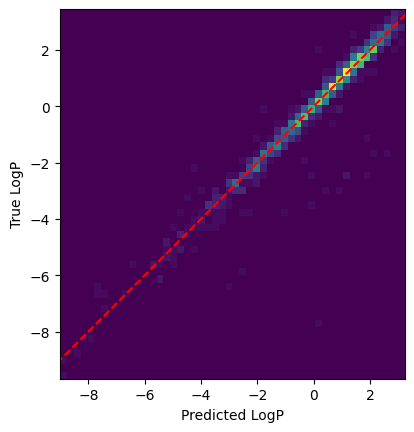

In [ ]:
heatmap, xedges, yedges = np.histogram2d(preds, gts, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.plot([min(gts), max(gts)], [min(gts), max(gts)], "r--")
plt.imshow(heatmap.T, extent=extent, origin="lower")
plt.xlabel("Predicted LogP")
plt.ylabel("True LogP")
plt.show()